## Audio Analysis of WAV files

Here we are looking for best way to reppresent audio recordings in a spectrogram for deeplearning

In [1]:
# load stuff we need
import json
import logging
import os
import time
import warnings
import librosa
import librosa.display # now seperate
import numpy as np
import pandas as pd
import pydub
import sklearn.preprocessing

from tqdm import tqdm

import h5py as h5py

from config import *

/usr/local/lib/python3.6/dist-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/usr/local/lib/python3.6/dist-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [6]:
os.getcwd()

'/tf/serval/serval'

In [48]:
# RESAMPLE 16 bit 16 kHz mono
import numpy as np
import scipy.signal
import librosa
import resampy

# Load in some audio
audio_file = '../data/wav_samples_custom/a_brommer_alarms/A-AS-roos-001.200120.135526.35.wav'
# audio_file
x, sr_orig = librosa.load(audio_file, sr=None, mono=True)

sr_new = 16000
# Or use the pre-built high-quality filter
y = resampy.resample(x, sr_orig, sr_new, filter='kaiser_best')

In [54]:
sd = np.sqrt(y.var())

(0.0, 3250.0)

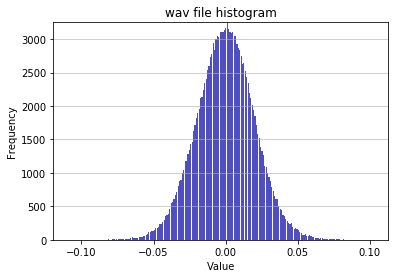

In [50]:
%matplotlib inline

import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=y, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('wav file histogram')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)



In [55]:
# add noise
import numpy as np
sd = np.sqrt(y.var())
noise = np.random.normal(0,sd,y.size)

(0.0, 3330.0)

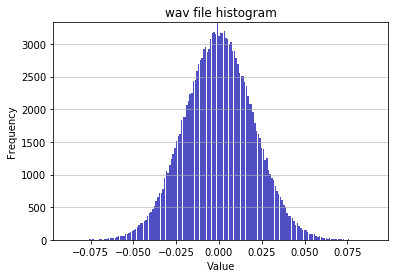

In [56]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=noise, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('wav file histogram')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)


In [37]:
# add noise to signal
y_new = y + noise

In [38]:
import soundfile as sf
f_new = 'test2.wav'
sf.write(f_new, y_new, sr_new, subtype='PCM_32')


In [39]:
from pydub import AudioSegment

song = AudioSegment.from_wav(f_new)

song



In [ ]:
# get info of the wav file
from pydub.utils import mediainfo
info = mediainfo(audio_file)
info

In [ ]:
sf.available_subtypes('WAV')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


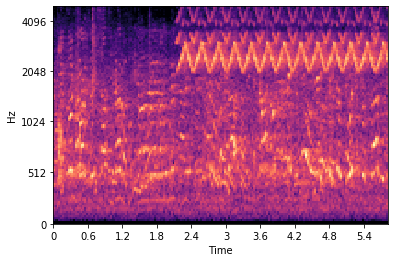

In [13]:
# CREATE SPECTROGRAM

# overrule settings in config
SAMPLING_RATE = sr_new  # Audio sampling rate, other parameters are hand-tuned for 44.1 kHz
CHUNK_SIZE = 882  # Spectrogram hop_size, 882 samples @ 44.1 kHz = 20 ms
FFT_SIZE = 2 * CHUNK_SIZE  # Spectrogram FFT window length

MEL_BANDS = 128  # 80 Number of mel frequency bands
MEL_FREQS = librosa.core.mel_frequencies(n_mels=MEL_BANDS)
#MEL_BANDS = 25
#MEL_FREQS = MEL_FREQS[0:25]

# current processing of the audio files
# default serval location
#audio_file = './dataset/audio/' + filename

audio = pydub.AudioSegment.from_file(audio_file).set_frame_rate(SAMPLING_RATE).set_channels(1)
audio = (np.fromstring(audio._data, dtype="int16") + 0.5) / (0x7FFF + 0.5) # convert to float

spec = librosa.feature.melspectrogram(audio, SAMPLING_RATE, n_fft=FFT_SIZE, fmin=0, fmax = 5000, 
                                      hop_length=CHUNK_SIZE, n_mels=MEL_BANDS) # MEL_BANDS
with warnings.catch_warnings():
    warnings.simplefilter('ignore')  # Ignore log10 zero division
    spec = librosa.core.perceptual_weighting(spec, MEL_FREQS, amin=1e-5, ref=1e-5,
                                             top_db=None)

spec = np.clip(spec, 0, 100)
#np.save(spec_file, spec.astype('float16'), allow_pickle=False)

librosa.display.specshow(spec,
                          y_axis='mel', sr=sr_new, fmin=0, fmax = 5000,
                          x_axis='time')

In [ ]:
# You can reload this cell to get a different clip at every try
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# bigger figure size
matplotlib.rcParams['figure.figsize'] = [12.0, 24.0] # default : [6.0, 4.0]

import librosa.display

import IPython.display

#all_recordings = glob.glob('ESC-50/*/*.ogg')
#clip = Clip(all_recordings[random.randint(0, len(all_recordings) - 1)])    

plt.subplot(6, 1, 1)
plt.title('{0} : {1}'.format( category, filename))
plt.plot(np.arange(0, len(audio)) / SAMPLING_RATE, audio)

plt.subplot(6, 1, 2)
librosa.display.specshow(spec, sr = SAMPLING_RATE, x_axis='frames', y_axis='linear', cmap='RdBu_r')

# linear spectrogram
plt.subplot(6, 1, 3)
D = librosa.amplitude_to_db(librosa.stft(audio), ref=np.max)
librosa.display.specshow(D, sr=SAMPLING_RATE, y_axis='linear', x_axis='time', cmap='RdBu_r')
#plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

plt.subplot(6, 1, 4)
D = np.abs(librosa.stft(audio))**2
S = librosa.feature.melspectrogram(S=D, sr=SAMPLING_RATE, fmin=0, fmax=2000)
librosa.display.specshow(librosa.power_to_db(S,
                                              ref=np.max),
                          y_axis='mel', sr=SAMPLING_RATE, fmax=2000,
                          x_axis='time')
#plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

# log scale spectrogram
plt.subplot(6, 1, 5)
S = librosa.feature.melspectrogram(audio, sr=SAMPLING_RATE, fmin=0, fmax=2000)
librosa.display.specshow(S,
                          y_axis='mel', sr=SAMPLING_RATE, fmax=2000,
                          x_axis='time')
#plt.colorbar(format='%+2.0f dB')
plt.title('Mel 2 spectrogram')
plt.tight_layout()

    
IPython.display.Audio(filename=audio_file, rate=SAMPLING_RATE) 

In [ ]:
# RESAMPLE 16 bit 16 kHz mono
import numpy as np
import scipy.signal
import librosa
import resampy

def resample(file):
    # Load in some audio
    x, sr_orig = librosa.load(file, sr=None, mono=True)

    sr_new = 16000
    # Or use the pre-built high-quality filter
    y = resampy.resample(x, sr_orig, sr_new, filter='kaiser_best') 
    return(y,sr_new)

In [ ]:
# DOUBLE DISTANCE
import os
from pydub import AudioSegment

def doubledistance(file,file_new,db = 6):
    # db is the decibels we want to reduce
    # db = 6 doubles the distance of the recording from the source
    song = AudioSegment.from_wav(file)
    song = song - db
    # save song with different filename
    filename, file_extension = os.path.splitext(file_new)
    new_file = filename + "_db" + str(db) + file_extension
    song.export(new_file, format="wav")
    return

In [ ]:
f = "../data/wav_samples_custom/b_brommers/B-Roos03.165538.57_dd12.wav"
fs = f.split('/')
f_new = '../'+fs[1]+'/'+fs[2]+'/'+fs[3]+'_trn'+'/'+fs[4]
f_new

directory = os.path.dirname(f_new) 
if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
# RESAMPLE AND ADJUST VOLUME FOR ALL WAVS IN FOLDER

import os
import random
from tqdm import tqdm
import soundfile as sf

path_original_wavs = "../data/amsterdam_custom_samples/original"
path_target_wavs = "../data/amsterdam_custom_samples/wav_samples"

files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path_original_wavs):
    for file in f:
        if '.wav' in file:
            files.append(os.path.join(r, file))

# proportion samples in train 
prop = 0.5
            
for f in tqdm(files):
    fs = f.split('/')
    # random choice between trn or eval label
    lbl = random.choices(['_trn','_eval'],[prop,1-prop])

    # trn eval split
    f_new = '../'+fs[1]+'/'+fs[2]+'/wav_samples/' +lbl[0]+'/0db/'+fs[4] +'/'+ fs[5]
    
    # create directory if not exists
    directory = os.path.dirname(f_new) 
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # resample 16 kHz mono
    y , sr = resample(f)
    
    ## O DECIBEL
    # save wav file 16 bit int
    sf.write(f_new, y, sr, subtype='PCM_32')
    
    # make copies doudle distance
    
    ## 6 DECIBEL
    
    #doubledistance(f,f_new, db = 6)  # 2x more distant
    
    # trn eval split
    f_new = '../'+fs[1]+'/'+fs[2]+'/wav_samples/' +lbl[0]+'/6db/'+fs[4] +'/'+ '6db_'+ fs[5]
    
    # create directory if not exists
    directory = os.path.dirname(f_new) 
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    # decibel
    db = 6.0
    gain = 10.0 ** (- db / 10.0)
    y = y * gain
    
    # save wav file 16 bit int
    sf.write(f_new, y, sr, subtype='PCM_32')
    
    ## 12 DECIBEL
    
    # trn eval split
    f_new = '../'+fs[1]+'/'+fs[2]+'/wav_samples/' +lbl[0]+'/12db/'+fs[4] +'/'+ '12db_'+ fs[5]
    
    # create directory if not exists
    directory = os.path.dirname(f_new) 
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    # reduce volume
    y = y * gain
    
    # save wav file 16 bit int
    sf.write(f_new, y, sr, subtype='PCM_32')

    ## 18 DECIBEL
    
    # trn eval split
    f_new = '../'+fs[1]+'/'+fs[2]+'/wav_samples/' +lbl[0]+'/18db/'+fs[4] +'/'+ '18db_'+ fs[5]
    
    # create directory if not exists
    directory = os.path.dirname(f_new) 
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    # reduce volume
    y = y * gain
    
    # save wav file 16 bit int
    sf.write(f_new, y, sr, subtype='PCM_32')



In [ ]:
10.0 ** (- 6 / 10.0)

In [ ]:
gain * gain * gain

In [ ]:
y
